# Final Assignment 
# Machine Learning for Robotics (RO47002) 2020/2021

Group Number:

Student 1 (name + student number):

Student 2 (name + student number):

---

*Note: Please remove this cell for the submission.*

## Task Description
In this final assignment, we revisit our robot from Practicum 2, which was able to pick up a pen after you trained it to recognize parts of the pen in its camera images. Now we want to teach the robot to be able to clean up a table after a meal. In particular, it needs to be able to pick up cutlery (forks, knives, spoons).  For that the robot needs to determine where the cutlery is located and where the handle is. The robot has a basic down-facing camera that it can place on top of the desk to inspect an area of interest. Your task is to design the machine learning method for this perception problem. To simplify the problem, we'll only consider a single type of cutlery (your choice of fork, spoon, or knife) and a single object visible in each camera picture.

## Deliverables
The deadline is Sunday October 25th, 23:59. Late submission is –1 grade point per day.

The main deliverable is a Jupyter Notebook, integrating the report (markdown cells) and the code. Submission is again in the form of a single ZIP file that includes all files required to run the notebook and reproduce the results (collected images, annotation data, loadable parameters, auxiliary scripts, etc.). The notebook needs to be able to run within 10 minutes on a high-end PC, performing all steps (also including the hyperparameter optimization and training).  Unlike previous lab assignments, there are no autograded cells or asserts, but we will grade the notebook manually. Therefore, you are free to add cells as you see fit, as long as the required sections are still present in the notebook.

## Grading Criteria
Below you will find an outline of the sections that the notebook needs to contain and what we expect for each part. More specific requirements are listed there as well. The indicated number of points, out of a total of 100, should give you a rough indication on how much effort to put into each part.

In general, we will not focus as much on the performance of the method you design, but rather the _level of understanding and argumentation about your design choices_. So, we are not only interested in WHAT you did, but will put a strong emphasis on your reasoning about the WHY. Try to synthesize rather than describing what you did step by step.

### Quality of the Report (20 points)
- Structure & Readability
 - Logical flow
 - Connection between parts
- English
 - Do not use short forms, like "isn't", "wouldn't".
 - Do not use colloquial style, like "a couple of".
 - Spell check and proofread your report.
- Level of detail
 - Strive for elegant, concise text - longer reports do not necessarily yield higher grades.
 - There is no need to re-explain theory. Assume that the target audience of the report has followed the course.
- Figures & Tables
 - Choose figures/plots/tables carefully. Only include those that add to the story of the report. Do not put the burden on the reviewer to figure out which results you basing your conclusions on, but specifically refer (parts of) the specific table/plot/figure when needed.
 - When comparing two or more signals display them in one plot. Explain the colors / line types. The scale of the plots must be carefully chosen in order to clearly convey the information intended. Label properly the axes in graphs (variables and units).
- Citations
 - If you use images, theory and methods beyond what was covered in the course, etc., always reference sources.


---

*Note: Please do not include the requirements in the submission.*

# Structure (inspired by the Machine Learning Project Checklist)

## Frame the Problem and Look at the Big Picture (10 points)
- How do you frame the learning problem? Please treat the main learning problem as a supervised learning problem. But can you best express it as a classification problem, a regression problem, an image segmentation problem, etc.? Note that there is not one best answer to this question, and the task could be addressed in different ways. We want to know your motivation for your selected approach.
- What are the runtime constraints, especially for predictions? How fast does the robot need to be able to process an image? What kind of platform do you assume (e.g., Arduino, Laptop, etc.)?
- How should performance be measured? What is the minimum performance required? What are the objectives? What kind of loss function is appropriate?
- What are promising algorithms?


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import os, glob

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import ipywidgets
from IPython.display import display

from collections import OrderedDict

import scipy
import skimage
import skimage.transform
import skimage.util

## Get the Data (15 points)
- Collect your own dataset, i.e., take pictures of your chosen type of cutlery on a table. What was your protocol? How many pictures do you need? What kind of variations did you try to capture? What kind of potential variations are you trying to avoid to capture?
- Annotate the data. Explain which options you considered and what you did in the end. If it is a custom annotation tool, include it in the submission, if you used an external tool, a link is sufficient
- Sample a test set
- *Note:* In contrast to Practicum 2, it is sufficient to just collect a single dataset and perform the training/testing split on that.

We are using knife images for training out dataset. Different kind of knives are selected with the different background. 
Annotation tool used was the one providd with Practicum 2.
Since we are not using a dataset which is dynamic we do not need compute the hash of each instances identifier.

To avoid the data snopping error we will split the dataset with the random seed constant so that the classifier is not trained on the test data set at all. We will keep the 20% of the dataset for the test purpose and the selection of the dataset will be random after shuffiling. To get the same shuffle and the same split of the data we will keep the random state of the test_train_split function.

Finding and Loading the Image print the image to check if the database is correct.

In [7]:
# Funtions for importing the files and the annotation
import glob
#image check funtion
def list_images_train(image_dir, filename_expression='*.JPG'):
    filenames = glob.glob(os.path.join(image_dir, filename_expression))
    filenames = sorted(filenames) # important for cross-platform compatiblity
    print(f'Found {len(filenames)} image files in the directory "{image_dir}"')
    return filenames

def list_images_test(image_dir, filename_expression='*.jpg'):
    filenames = glob.glob(os.path.join(image_dir, filename_expression))
    filenames = sorted(filenames) # important for cross-platform compatiblity
    print(f'Found {len(filenames)} image files in the directory "{image_dir}"')
    return filenames



In [15]:
# Importing the database

#making the list of the filenames
IMAGE_DIR = 'knife_database/RAW' #for the training data
TEST_DATA = 'test_database'   #for the test data
filenames_train = list_images_train(IMAGE_DIR)
filenames_test = list_images_test(TEST_DATA)
N_train = len(filenames_train)
N_test = len(filenames_test)

#loading the list of the images in a single variable for the train dataset
Is_train = [plt.imread(filename) for filename in filenames_train]
print('loaded %d images for the training data' % len(Is_train))
print("The shape of the ",np.shape(Is_train))

#loading the list of the images in a single variable for the test dataset
Is_test = [plt.imread(filename) for filename in filenames_test]
print('loaded %d images for the training data' % len(Is_test))
print("The shape of the ",np.shape(Is_test))

#loading the annotaion for the test dataset
#using picle module to import the annotations of the image
import pickle

annots_train = None # store your results in the variable `annots_train`
annots_test = None # store your results in the variable `annots_test`
annot_train_filename = os.path.join(IMAGE_DIR, 'annots.npy')
annot_test_filename = os.path.join(TEST_DATA, 'annots.npy')

#LOADING THE ANNOTATION FOR THE TRAIN DATASET
annot_exists = os.path.isfile(annot_train_filename)
print(f'Looking for annotations file "{annot_train_filename}":', 'found' if annot_exists else 'NOT found')

if annot_exists:
    print('Loading annotations')
    annots_train = pickle.load(open(annot_train_filename, 'rb'))
else:
    print('Initializing empty annotations array')
    annots_train = np.zeros((N,4)) 
    
#LOADING THE ANNOTATION FOR THE TEST DATASET
annot_exists = os.path.isfile(annot_train_filename)
print(f'Looking for annotations file "{annot_test_filename}":', 'found' if annot_exists else 'NOT found')

if annot_exists:
    print('Loading annotations')
    annots_test = pickle.load(open(annot_test_filename, 'rb'))
else:
    print('Initializing empty annotations array')
    annots_test = np.zeros((N,4)) 


Found 35 image files in the directory "knife_database/RAW"
Found 17 image files in the directory "test_database"
loaded 35 images for the training data
The shape of the  (35, 768, 1024, 3)
loaded 17 images for the training data
The shape of the  (17, 768, 1024, 3)
Looking for annotations file "knife_database/RAW/annots.npy": found
Loading annotations
Looking for annotations file "test_database/annots.npy": found
Loading annotations


## Explore the Data (5 points)
- Visualize the data
- Study its properties


We can visualize the annotaion of the data on the image of the knife.
Creat a copy fo the traing set to play with it
Since are annotaion exist for all the images therefore we do not have to fill the gaps in the data


Displaying the charecterstics of the TRAIN images 



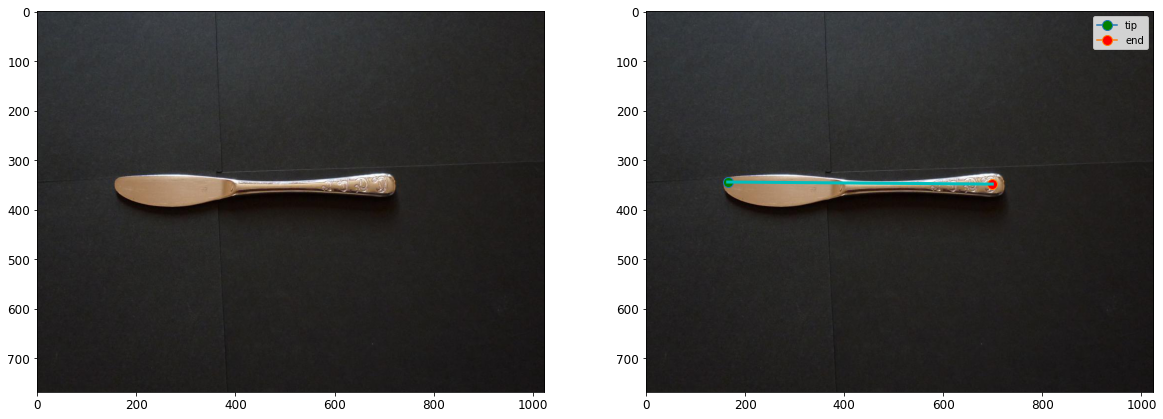

FOR THE SINGLE IMAGE
The height of the image is 768
The width of the image is 1024
The number of channel of the image is 3
The datatype of the single image is = uint8 

FOR THE GROUP OF DATA
The shape of the image array is  (35, 768, 1024, 3)
The dtype of the image array is = uint8 

FOR THE ANNOTATION MATRIX
The shape of the annotation matrix is (35, 4)
The datatype of the annotation matrix is = float64
Displaying the charecterstics of the TEST images 



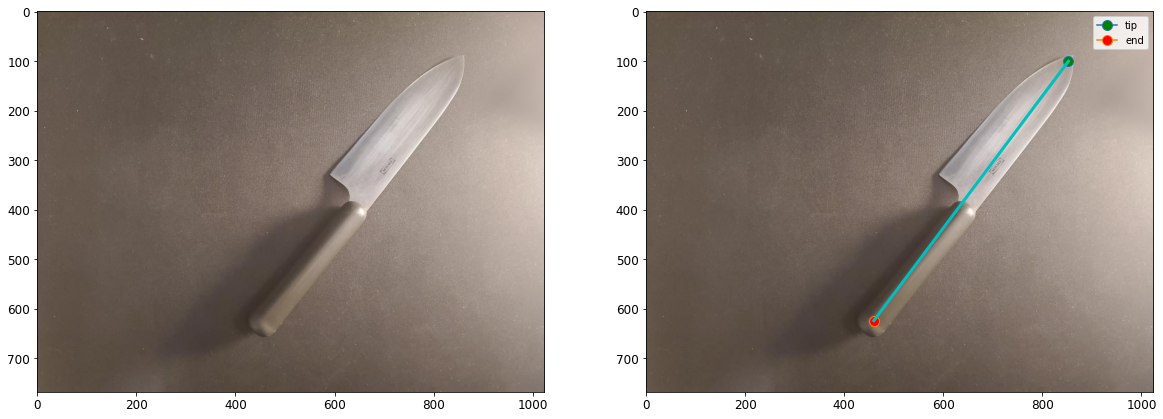

FOR THE SINGLE IMAGE
The height of the image is 768
The width of the image is 1024
The number of channel of the image is 3
The datatype of the single image is = uint8 

FOR THE GROUP OF DATA
The shape of the image array is  (17, 768, 1024, 3)
The dtype of the image array is = uint8 

FOR THE ANNOTATION MATRIX
The shape of the annotation matrix is (17, 4)
The datatype of the annotation matrix is = float64


In [18]:
#calculating the width and the height of the image
import numpy as np 

def show_annotation(I, p1, p2):
    plt.figure(figsize=(20,24))
    plt.subplot(1,2,1)
    plt.imshow(I)
    plt.subplot(1,2,2)
    plt.imshow(I)
    x = np.array([p1[0],p2[0]])
    y = np.array([p1[1],p2[1]])
    #2. plotting the green and the red circle
    plt.plot(p1[0],p1[1], marker="o", markersize=10, markerfacecolor="g", label="tip" )
    plt.plot(p2[0],p2[1], marker="o", markersize=10, markerfacecolor="r", label="end" )
    plt.plot(x,y, linewidth=3, color="c" )
    plt.legend(loc='upper right')
    
    plt.show()

#Enter the index of the image to be displayed for the trainig and the test dataset
img_idx_train = 3 #enter a value from 0 to 34
I_train = Is_train[img_idx_train]
p1_train = annots_train[img_idx_train,:2].copy() # copy of point 1 of the pen of the training dataset
p2_train = annots_train[img_idx_train,2:].copy() #copy of point 2 of the pen of the training dataset

img_idx_test = 3  #enter a value from 0 to 16
I_test = Is_test[img_idx_test]
p1_test = annots_test[img_idx_test,:2].copy() # copy of point 1 of the pen of the test dataset
p2_test = annots_test[img_idx_test,2:].copy() #copy of point 2 of the pen of the test dataset

#calling the show_annotation function to show the orignal imge and the annotation in the image
#Exploring the data of the single image of the training dataset
print("Displaying the charecterstics of the TRAIN images \n")
show_annotation(I_train, p1_train, p2_train)

print("FOR THE SINGLE IMAGE")
print("The height of the image is",np.shape(I_train)[0])
print("The width of the image is",np.shape(I_train)[1])
print("The number of channel of the image is",np.shape(I_train)[2])
print("The datatype of the single image is =",I_train.dtype,"\n")

print("FOR THE GROUP OF DATA")
print("The shape of the image array is ",np.shape(Is_train))
print("The dtype of the image array is =",np.asarray(Is_train).dtype,"\n")

print("FOR THE ANNOTATION MATRIX")
print("The shape of the annotation matrix is",np.shape(annots_train))
print("The datatype of the annotation matrix is =",annots_train.dtype)


#Exploring the data of the single image fo the test dataset
print("Displaying the charecterstics of the TEST images \n")
show_annotation(I_test, p1_test, p2_test)

print("FOR THE SINGLE IMAGE")
print("The height of the image is",np.shape(I_test)[0])
print("The width of the image is",np.shape(I_test)[1])
print("The number of channel of the image is",np.shape(I_test)[2])
print("The datatype of the single image is =",I_test.dtype,"\n")

print("FOR THE GROUP OF DATA")
print("The shape of the image array is ",np.shape(Is_test))
print("The dtype of the image array is =",np.asarray(Is_test).dtype,"\n")

print("FOR THE ANNOTATION MATRIX")
print("The shape of the annotation matrix is",np.shape(annots_test))
print("The datatype of the annotation matrix is =",annots_test.dtype)


## Prepare the Data (10 points)
- Pre-process the data (e.g. down-sample, color channels)
- Extract features (if needed by chosen algorithms)


Use the cross validation for training and testing on the data by splitting it into subsets

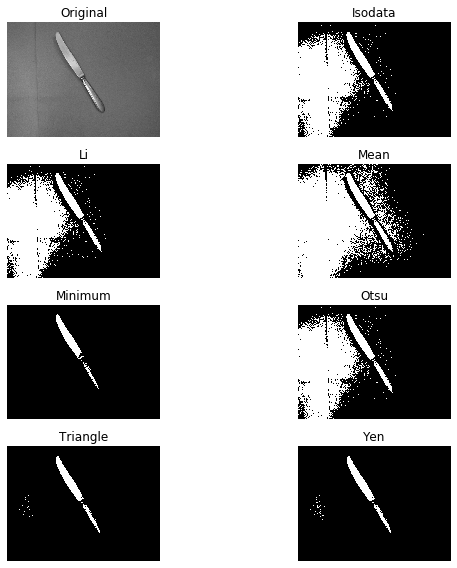

In [5]:
from skimage import data
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.filters import try_all_threshold


img_idx = 21
I = Is[img_idx]
grayscale_image = rgb2gray(I)

fig, ax = try_all_threshold(grayscale_image, figsize=(10, 8), verbose=False)
plt.show()


In [6]:
#For the patch creation extraction 
import skimage as sk

FEAT_SIZE = (9,9,3)

def patch_to_vec(P):
    x = sk.transform.resize(P,(9,9,3))
    return x

WIN_SIZE = (100, 100, 3)

# for convenience, half the window
HALF_WIN_SIZE = (WIN_SIZE[0] // 2, WIN_SIZE[1] // 2, WIN_SIZE[2])

def get_patch_at_point(I, p):
    p_x = int(p[0])
    p_y = int(p[1])
    P = I[p_y - HALF_WIN_SIZE[1]:p_y + HALF_WIN_SIZE[1],p_x - HALF_WIN_SIZE[0]:p_x + HALF_WIN_SIZE[0],:]
    return P

def sample_points_grid(I):
    # window centers
    W = np.shape(I)[1]
    H = np.shape(I)[0]
    
    step_size = (WIN_SIZE[0]//2, WIN_SIZE[1]//2)
    min_ys = range(0, H-WIN_SIZE[0]+1, step_size[0])
    min_xs = range(0, W-WIN_SIZE[1]+1, step_size[1])
    center_ys = range(HALF_WIN_SIZE[0], H-HALF_WIN_SIZE[0]+1, step_size[0])
    center_xs = range(HALF_WIN_SIZE[1], W-HALF_WIN_SIZE[1]+1, step_size[1])
    centers = np.array(np.meshgrid(center_xs, center_ys))
    centers = centers.reshape(2,-1).T
    centers = centers.astype(float) 
    
    # add a bit of random offset
    centers += np.random.rand(*centers.shape) * 10 
    
    # discard points close to border where we can't extract patches
    centers = remove_points_near_border(I, centers)
    
    return centers

def sample_points_around_pen(I, p1, p2):
    Nu = 100 # uniform samples (will mostly be background, and some non-background)
    Nt = 50 # samples at target locations, i.e. near start, end, and middle of pen
    
    target_std_dev = np.array(HALF_WIN_SIZE[:2])/3 # variance to add to locations

    upoints = sample_points_grid(I)
    idxs = np.random.choice(upoints.shape[0], Nu)
    upoints = upoints[idxs,:]
    
    
    # sample around target locations
    tpoints1 = np.random.randn(Nt,2)
    tpoints1 = tpoints1 * target_std_dev + p1

    tpoints2 = np.random.randn(Nt,2)
    tpoints2 = tpoints2 * target_std_dev + p2

    # sample over length pen
    alpha = np.random.rand(Nt)
    tpoints3 = p1[None,:] * alpha[:,None] + p2[None,:] * (1. - alpha[:,None])
    tpoints3 = tpoints3 + np.random.randn(Nt,2) * target_std_dev
    
    # merge all points
    points = np.vstack((upoints, tpoints1, tpoints2, tpoints3))
    
    # discard points close to border where we can't extract patches
    points = remove_points_near_border(I, points)
    
    return points

def remove_points_near_border(I, points):
    W = np.shape(I)[1]
    H = np.shape(I)[0]

    # discard points that are too close to border
    points = points[points[:,0] > HALF_WIN_SIZE[1],:]
    points = points[points[:,1] > HALF_WIN_SIZE[0],:]
    points = points[points[:,0] < W - HALF_WIN_SIZE[1],:]
    points = points[points[:,1] < H - HALF_WIN_SIZE[0],:]
    
    return points

CLASS_NAMES = [
    'background', # class 0
    'tip',        # class 1
    'end',        # class 2
    'middle'      # class 3
]

def make_labels_for_points(I, p1, p2, points):
    """ Determine the class label (as an integer) on point distance to different parts of the pen """
    num_points = points.shape[0]
    
    # for all points ....
    
    # ... determine their distance to tip of the pen
    dist1 = points - p1
    dist1 = np.sqrt(np.sum(dist1 * dist1, axis=1))
    
    # ... determine their distance to end of the pen
    dist2 = points - p2
    dist2 = np.sqrt(np.sum(dist2 * dist2, axis=1))

    # ... determine distance to pen middle
    alpha = np.linspace(0.2, 0.8, 100)
    midpoints = p1[None,:] * alpha[:,None] + p2[None,:] * (1. - alpha[:,None]) 
    dist3 = scipy.spatial.distance_matrix(midpoints, points)
    dist3 = np.min(dist3, axis=0)
    
    # the class label of a point will be determined by which distance is smallest
    #    and if that distance is at least below `dist_thresh`, otherwise it is background
    dist_thresh = WIN_SIZE[0] * 2./3.

    # store distance to closest point in each class in columns
    class_dist = np.zeros((num_points, 4))
    class_dist[:,0] = dist_thresh
    class_dist[:,1] = dist1
    class_dist[:,2] = dist2
    class_dist[:,3] = dist3
    
    # the class label is now the column with the lowest number
    labels = np.argmin(class_dist, axis=1)
    
    return labels

def count_classes(labels):
   
    zeros = 0
    ones = 0
    twos = 0
    threes = 0
    for i in range(len(labels)):
        if (labels[i] == 0):
            zeros = zeros + 1
        if (labels[i] == 1):
            ones = ones + 1
        if (labels[i] == 2):
            twos = twos + 1
        if (labels[i] == 3):
            threes = threes + 1
        
    count = np.array([zeros,ones,twos,threes])    
    return count

def extract_patches(I, p1, p2, strategy=None):
    
    # by default, if no strategy is explicitly defined, use strategy 2
    if strategy == 1:
        points = sample_points_grid(I)
    if strategy == 2 or strategy is None:
        points = sample_points_around_pen(I, p1, p2)
    
    # determine the labels of the points
    labels = make_labels_for_points(I, p1, p2, points)
    
    xs = []
    for p in points:
        P = get_patch_at_point(I, p)
        x = patch_to_vec(P)
        xs.append(x)
    X = np.array(xs)

    return X, labels, points

def extract_multiple_images(idxs, strategy=None):
    Xs = []
    ys = []
    points = []
    imgids = []

    for step, idx in enumerate(idxs):
        I = Is[idx]
        I_X, I_y, I_points = extract_patches(I, annots[idx,:2], annots[idx,2:], strategy=strategy)

        classcounts = count_classes(I_y)
        print(f'image {idx}, class count = {classcounts}')

        Xs.append(I_X)
        ys.append(I_y)
        points.append(I_points)
        imgids.append(np.ones(len(I_y),dtype=int)*idx)

    Xs = np.vstack(Xs)
    ys = np.hstack(ys)
    points = np.vstack(points)
    imgids = np.hstack(imgids)
    
    return Xs, ys, points, imgids

The training and the test set are not split randomly but sequentailly according to the index number so that the classifier never sees the the test data before the prediction when the code is run multiple times.

In [31]:
#spliting the images in the training and the test set
train_imgs = list(range(0,24))
test_imgs = list(range(24,len(Is)))
X_train, y_train, points_train, imgids_train = extract_multiple_images(train_imgs)
X_test, y_test, points_test, imgids_test = extract_multiple_images(test_imgs)

image 0, class count = [87 53 56 54]
image 1, class count = [84 57 60 49]
image 2, class count = [87 54 57 52]
image 3, class count = [88 55 57 50]
image 4, class count = [85 56 61 48]
image 5, class count = [89 56 57 48]
image 6, class count = [87 56 59 48]
image 7, class count = [87 53 60 50]
image 8, class count = [88 56 55 51]
image 9, class count = [85 57 55 53]
image 10, class count = [88 53 59 50]
image 11, class count = [89 58 59 44]
image 12, class count = [86 59 59 46]
image 13, class count = [87 53 53 57]
image 14, class count = [85 55 59 51]
image 15, class count = [86 54 55 55]
image 16, class count = [93 53 55 49]
image 17, class count = [89 65 57 39]
image 18, class count = [86 59 57 48]
image 19, class count = [90 59 57 44]
image 20, class count = [83 57 58 52]
image 21, class count = [84 53 57 55]
image 22, class count = [88 55 58 49]
image 23, class count = [88 60 61 41]
image 24, class count = [89 53 55 53]
image 25, class count = [87 57 60 46]
image 26, class count 

## Shortlist Promising Models (15 points)
- Compare at least 2 models. One of them needs to be a neural network, one of them needs to be not a neural network.
- Perform dimensionality reduction (if needed)
- Roughly tune those models
- Evaluate the models in terms of performance, bias, variance, etc.
- Pick one algorithm to develop further


In [71]:
print(X_train.shape)
print(np.reshape(X_train,(len(X_train),243)).shape)

(5999, 243)
(5999, 243)


In [85]:
# Creating neural networks in Keras 
# importing the related libraries
import glob# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# Common imports
import numpy as np
import os, glob
import scipy

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import ipywidgets
from IPython.display import display

from collections import OrderedDict

import scipy
import skimage
import skimage.transform
import skimage.util

import tensorflow as tf
from tensorflow import keras

In [86]:
checkpoint_path = "learned_weights/weights.best.hdf5"
checkpoint_dir = os.path.dirname(checkpoint_path)

import os
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 save_freq='epoch',
                                                 verbose=1)

In [87]:
#defining the config layer function
def config_layers(X_train, NNH_1, NNH_2, y_train):
    num_input_units = X_train.shape[1]
    NNH_1 = NNH_1
    NNH_2 = NNH_2
    num_logits = len(list(set(y_train)))
    return num_input_units, NNH_1, NNH_2, num_logits
def one_hot_encoding(y_orig):
    # YOUR CODE HERE
    y_orig = np.asarray(y_orig)
    y_one_hot = np.zeros((y_orig.shape[0], y_orig.max()+1))
    y_one_hot[np.arange(y_orig.shape[0]),y_orig] = 1
    y_one_hot = y_one_hot.astype(np.uint8)
    return y_one_hot
def our_predict(model, X):
    # YOUR CODE HERE
    y_predict_raw = model.predict(X)
    y_predict = np.argmax(y_predict_raw,axis=1)
    #raise NotImplementedError()
    return y_predict, y_predict_raw
def plot_image_classification_results(img_idx, y_pred_raw, points, imgids, Is):
    mask = imgids == img_idx
    points = points[mask,:]
    predictions = y_pred_raw[mask,:]
    y_pred = np.argmax(predictions, axis = 1)
    best_idx1 = predictions[:,1].argmax()
    best_idx2 = predictions[:,2].argmax()
    
    # load image
    I = Is[img_idx]

    plt.figure()
    plt.imshow(I)
    plt.plot(points[y_pred==0, 0], points[y_pred==0, 1], '.r')
    plt.plot(points[y_pred==3, 0], points[y_pred==3, 1], '.y')
    plt.plot(points[y_pred==1, 0], points[y_pred==1, 1], '.g')
    plt.plot(points[y_pred==2, 0], points[y_pred==2, 1], '.b')
    plt.plot(points[(best_idx1, best_idx2), 0], points[(best_idx1, best_idx2), 1], 'c-', linewidth=2)
    plt.plot(points[best_idx1, 0], points[best_idx1, 1], 'co')
    plt.show()
    
def plot_nth_train_result(n):
    plot_image_classification_results(test_img_idxs[n], y_predict_raw, points_test, imgids_test, Is)

In [88]:
from tensorflow.python.keras.layers import Dense

# defining the keras model
X_train = np.reshape(X_train,(len(X_train),243))
X_test = np.reshape(X_test,(len(X_test),243))

num_input_units, NNH_1, NNH_2, num_logits = config_layers(X_train, 173, 67, y_train)

image_model = keras.models.Sequential()
image_model.add(Dense(NNH_1, input_dim=num_input_units, activation='relu'))
image_model.add(Dense(NNH_2, input_dim=num_input_units, activation='relu'))
image_model.add(Dense(num_logits, activation='softmax'))

print(num_input_units)

243


In [76]:
# compiling the keras model
from tensorflow.keras import metrics
optimizer = keras.optimizers.Adam(lr=0.01)
image_model.compile(optimizer=optimizer , loss='binary_crossentropy' , metrics=['accuracy'])
y_train_one_hot = one_hot_encoding(y_train)
print(X_train.shape)

(5999, 243)


In [77]:
#fitting the keras model
validation_split = 0.25
epochs = 50
batch_size = 5
y_train_one_hot = one_hot_encoding(y_train)
history = image_model.fit(X_train, y_train_one_hot, validation_split=validation_split,\
                    epochs=epochs, batch_size=batch_size, callbacks = [cp_callback])

Train on 4499 samples, validate on 1500 samples
Epoch 1/50
4440/4499 [============================>.] - ETA: 0s - loss: 0.3434 - accuracy: 0.8503
Epoch 00001: val_accuracy improved from -inf to 0.89717, saving model to learned_weights/weights.best.hdf5
4499/4499 [==============================] - 2s 431us/sample - loss: 0.3415 - accuracy: 0.8514 - val_loss: 0.2776 - val_accuracy: 0.8972
Epoch 2/50
4415/4499 [============================>.] - ETA: 0s - loss: 0.2175 - accuracy: 0.9186
Epoch 00002: val_accuracy improved from 0.89717 to 0.91583, saving model to learned_weights/weights.best.hdf5
4499/4499 [==============================] - 2s 380us/sample - loss: 0.2169 - accuracy: 0.9190 - val_loss: 0.2346 - val_accuracy: 0.9158
Epoch 3/50
4345/4499 [===========================>..] - ETA: 0s - loss: 0.1999 - accuracy: 0.9244
Epoch 00003: val_accuracy did not improve from 0.91583
4499/4499 [==============================] - 2s 357us/sample - loss: 0.1993 - accuracy: 0.9249 - val_loss: 0.250

Epoch 28/50
4385/4499 [============================>.] - ETA: 0s - loss: 0.1110 - accuracy: 0.9619
Epoch 00028: val_accuracy did not improve from 0.95500
4499/4499 [==============================] - 2s 348us/sample - loss: 0.1132 - accuracy: 0.9608 - val_loss: 0.1670 - val_accuracy: 0.9355
Epoch 29/50
4475/4499 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9628
Epoch 00029: val_accuracy did not improve from 0.95500
4499/4499 [==============================] - 2s 352us/sample - loss: 0.1087 - accuracy: 0.9629 - val_loss: 0.2177 - val_accuracy: 0.9478
Epoch 30/50
4345/4499 [===========================>..] - ETA: 0s - loss: 0.0966 - accuracy: 0.9681
Epoch 00030: val_accuracy did not improve from 0.95500
4499/4499 [==============================] - 2s 352us/sample - loss: 0.1014 - accuracy: 0.9668 - val_loss: 0.2646 - val_accuracy: 0.9123
Epoch 31/50
4380/4499 [============================>.] - ETA: 0s - loss: 0.1270 - accuracy: 0.9529
Epoch 00031: val_accuracy di

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


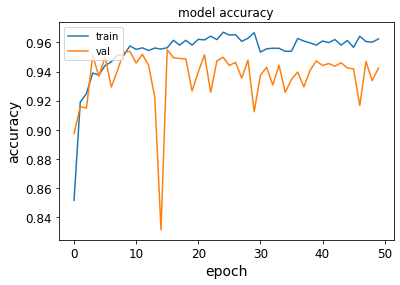

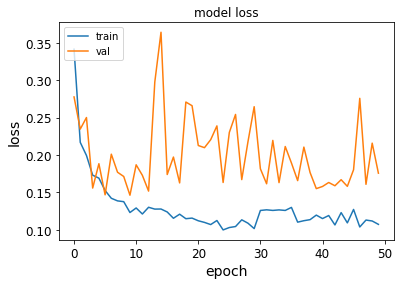

2746/2746 [==============================] - 0s 49us/sample - loss: 0.3757 - accuracy: 0.8742
Accuracy: 87.42


interactive(children=(IntSlider(value=5, description='n', max=10), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_nth_train_result(n)>

In [78]:
#plotting the training log
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#calculating the accuracy of the predictions
y_test_one_hot = one_hot_encoding(y_test)
_, accuracy = image_model.evaluate(X_test, y_test_one_hot)
print('Accuracy: %.2f' % (accuracy*100))

y_predict_train, _ = our_predict(image_model, X_train)

test_img_idxs = np.unique(imgids_test)
y_predict, y_predict_raw = our_predict(image_model, X_test)
ipywidgets.interact(plot_nth_train_result, n=(0,len(test_img_idxs)-1))

In [32]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

sgd_clf = SGDClassifier(loss="log" , max_iter=1000, tol=1e-3, random_state=42)
dt_clf = DecisionTreeClassifier(random_state=42) # this should be the Decision Tree classifer
rf_clf = RandomForestClassifier(random_state=42)

X_train = np.reshape(X_train,(len(X_train),243))
X_test = np.reshape(X_test,(len(X_test),243))
sgd_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)

y_train_pred_sgd = sgd_clf.predict(X_train)
y_train_pred_dt = dt_clf.predict(X_train)
y_train_pred_rf = rf_clf.predict(X_train)

print("SGD training accuracy score = ",accuracy_score(y_train, y_train_pred_sgd),"\n")
print("DT training accuracy score = ",accuracy_score(y_train, y_train_pred_dt),"\n")
print("RF training accuracy score = ",accuracy_score(y_train, y_train_pred_rf),"\n")

#now testing on the test data
y_test_pred_sgd = sgd_clf.predict(X_test)
y_test_pred_dt = dt_clf.predict(X_test)
y_test_pred_rf = rf_clf.predict(X_test)

print("SGD test accuracy score = ",accuracy_score(y_test, y_test_pred_sgd),"\n")
print("DT test accuracy score = ",accuracy_score(y_test, y_test_pred_dt),"\n")
print("RF test accuracy score = ",accuracy_score(y_test, y_test_pred_rf),"\n")



/home/shantanu/anaconda3/envs/tf2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


SGD training accuracy score =  0.8611435239206534 

DT training accuracy score =  1.0 

RF training accuracy score =  0.9979996666111018 

SGD test accuracy score =  0.7720320466132556 

DT test accuracy score =  0.5906773488710853 

RF test accuracy score =  0.6755280407865987 



In [ ]:
#testing the accuracy of the algorithm on the test set

## Fine-Tune the System (15 points)
- Perform hyperparameter optimization (including pre-processing steps)
- Evaluate the final model (similar to “Shortlist Promising Models” above)
- Evaluate if your dataset was large and rich enough
- Save the parameters of your best model to your harddrive (use pickle for sklearn or built-in save/load for keras), you will need to be able to reload your model without training in the next step. Be sure to include the saved parameters in your zip file so we can evaluate your best model too even without rerunning the notebook up to here.


Use the grid search method to optimize the hyperparameter of any classifier


In [66]:
#Fine tuning the random classifier model using the gridsearch method
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import timeit


start = timeit.default_timer()

param_grid = [{'bootstrap': [True,False],'n_estimators': [10,20,30,50,100,200,300], 'max_features': ['auto','log2'],
              'min_samples_leaf': [50]}]
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_clf, param_grid, cv=5,
scoring='accuracy',
return_train_score=True,n_jobs=-1)
grid_search.fit(X_train,y_train)

print(grid_search.best_params_)

stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time),'secs') 

{'bootstrap': False, 'max_features': 'auto', 'min_samples_leaf': 50, 'n_estimators': 200}
Program Executed in 107.0919190780005 secs


In [ ]:
#for random forest classifier
#bootstrap = false
#n_estimators = higher give better results maxcap at 200
#max_feature = considers the number of features to take to create the tree auto selects more features than log2
#min_leaf_size = the size of the dataset which makes the leaf of the decision tree, low values are preone to capturing
# hence a decent value of 50 is ecommended


In [83]:
#using RandomsearchCV for tuning the RandomForest classifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import timeit

start = timeit.default_timer()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,10,50]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Creating the Parameters grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(param_grid)

# runnig the classifier using the random search
rf_clf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf_clf, param_grid, cv=5,
scoring='accuracy',
return_train_score=True,n_jobs=-1,n_iter = 50)

random_search.fit(X_train,y_train)

stop = timeit.default_timer()
execution_time = stop - start
print("Program Executed in "+str(execution_time),'secs') 


{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 10, 50], 'bootstrap': [True, False]}
Program Executed in 3915.939231564 secs


In [84]:
print(random_search.best_params_)

{'n_estimators': 1800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}


In [ ]:
# Tuning the Neural Networks
from tensorflow.python.keras.layers import Dense
from tensorflow.keras import metrics


def image_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=num_input_units):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        
    model.add(keras.layers.Dense(num_logits, activation='softmax'))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

        
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(image_model)

param_distribs = {
                        "n_hidden": [0, 1, 2],
                        "n_neurons": np.arange(25,30),
                        "learning_rate": reciprocal(3e-4, 3e-2),
                }

validation_split = 0.25
epochs = 50
batch_size = 5

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train_one_hot,
                            validation_split=validation_split, epochs=epochs,batch_size=batch_size,
                            callbacks=[cp_callback])


print(rnd_search_cv.best_params_)


Train on 2999 samples, validate on 1000 samples
Epoch 1/50
2999/2999 [==============================] - 1s 333us/sample - loss: 0.1848 - val_loss: 0.1840
Epoch 2/50
2999/2999 [==============================] - 1s 289us/sample - loss: 0.1792 - val_loss: 0.1816
Epoch 3/50
2999/2999 [==============================] - 1s 284us/sample - loss: 0.1770 - val_loss: 0.1806
Epoch 4/50
2999/2999 [==============================] - 1s 282us/sample - loss: 0.1759 - val_loss: 0.1798
Epoch 5/50
2999/2999 [==============================] - 1s 283us/sample - loss: 0.1749 - val_loss: 0.1790
Epoch 6/50
2999/2999 [==============================] - 1s 271us/sample - loss: 0.1740 - val_loss: 0.1783
Epoch 7/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.1731 - val_loss: 0.1775
Epoch 8/50
2999/2999 [==============================] - 1s 266us/sample - loss: 0.1722 - val_loss: 0.1768
Epoch 9/50
2999/2999 [==============================] - 1s 275us/sample - loss: 0.1713 - val_loss: 0.176

Epoch 33/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.1530 - val_loss: 0.1624
Epoch 34/50
2999/2999 [==============================] - 1s 274us/sample - loss: 0.1523 - val_loss: 0.1620
Epoch 35/50
2999/2999 [==============================] - 1s 287us/sample - loss: 0.1517 - val_loss: 0.1615
Epoch 36/50
2999/2999 [==============================] - 1s 295us/sample - loss: 0.1510 - val_loss: 0.1611
Epoch 37/50
2999/2999 [==============================] - 1s 278us/sample - loss: 0.1504 - val_loss: 0.1607
Epoch 38/50
2999/2999 [==============================] - 1s 272us/sample - loss: 0.1498 - val_loss: 0.1603
Epoch 39/50
2999/2999 [==============================] - 1s 270us/sample - loss: 0.1492 - val_loss: 0.1598
Epoch 40/50
2999/2999 [==============================] - 1s 281us/sample - loss: 0.1486 - val_loss: 0.1594
Epoch 41/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.1480 - val_loss: 0.1590
Epoch 42/50
2999/2999 [==============

2999/2999 [==============================] - 1s 273us/sample - loss: 0.1787 - val_loss: 0.1786
Epoch 15/50
2999/2999 [==============================] - 1s 272us/sample - loss: 0.1781 - val_loss: 0.1780
Epoch 16/50
2999/2999 [==============================] - 1s 269us/sample - loss: 0.1776 - val_loss: 0.1773
Epoch 17/50
2999/2999 [==============================] - 1s 303us/sample - loss: 0.1770 - val_loss: 0.1767
Epoch 18/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.1764 - val_loss: 0.1761
Epoch 19/50
2999/2999 [==============================] - 1s 286us/sample - loss: 0.1759 - val_loss: 0.1755
Epoch 20/50
2999/2999 [==============================] - 1s 273us/sample - loss: 0.1753 - val_loss: 0.1749
Epoch 21/50
2999/2999 [==============================] - 1s 282us/sample - loss: 0.1748 - val_loss: 0.1743
Epoch 22/50
2999/2999 [==============================] - 1s 253us/sample - loss: 0.1743 - val_loss: 0.1737
Epoch 23/50
2999/2999 [==========================

2999/2999 [==============================] - 1s 277us/sample - loss: 0.1638 - val_loss: 0.1621
Epoch 47/50
2999/2999 [==============================] - 1s 298us/sample - loss: 0.1635 - val_loss: 0.1617
Epoch 48/50
2999/2999 [==============================] - 1s 292us/sample - loss: 0.1631 - val_loss: 0.1613
Epoch 49/50
2999/2999 [==============================] - 1s 274us/sample - loss: 0.1628 - val_loss: 0.1609
Epoch 50/50
2000/2000 [==============================] - 0s 35us/sample - loss: 0.1598
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 1s 276us/sample - loss: 0.1863 - val_loss: 0.1834
Epoch 2/50
3000/3000 [==============================] - 1s 222us/sample - loss: 0.1831 - val_loss: 0.1808
Epoch 3/50
3000/3000 [==============================] - 1s 251us/sample - loss: 0.1815 - val_loss: 0.1791
Epoch 4/50
3000/3000 [==============================] - 1s 233us/sample - loss: 0.1804 - val_loss: 0.1779
Epoch 5/50
3000/3000 [===

2999/2999 [==============================] - 1s 306us/sample - loss: 0.1740 - val_loss: 0.1767
Epoch 10/50
2999/2999 [==============================] - 1s 317us/sample - loss: 0.1728 - val_loss: 0.1758
Epoch 11/50
2999/2999 [==============================] - 1s 311us/sample - loss: 0.1716 - val_loss: 0.1749
Epoch 12/50
2999/2999 [==============================] - 1s 323us/sample - loss: 0.1704 - val_loss: 0.1740
Epoch 13/50
2999/2999 [==============================] - 1s 289us/sample - loss: 0.1692 - val_loss: 0.1732
Epoch 14/50
2999/2999 [==============================] - 1s 270us/sample - loss: 0.1681 - val_loss: 0.1723
Epoch 15/50
2999/2999 [==============================] - 1s 288us/sample - loss: 0.1669 - val_loss: 0.1714
Epoch 16/50
2999/2999 [==============================] - 1s 278us/sample - loss: 0.1657 - val_loss: 0.1705
Epoch 17/50
2999/2999 [==============================] - 1s 291us/sample - loss: 0.1646 - val_loss: 0.1697
Epoch 18/50
2999/2999 [==========================

2999/2999 [==============================] - 1s 291us/sample - loss: 0.1393 - val_loss: 0.1515
Epoch 42/50
2999/2999 [==============================] - 1s 288us/sample - loss: 0.1384 - val_loss: 0.1510
Epoch 43/50
2999/2999 [==============================] - 1s 291us/sample - loss: 0.1375 - val_loss: 0.1504
Epoch 44/50
2999/2999 [==============================] - 1s 295us/sample - loss: 0.1365 - val_loss: 0.1499
Epoch 45/50
2999/2999 [==============================] - 1s 281us/sample - loss: 0.1357 - val_loss: 0.1492
Epoch 46/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.1348 - val_loss: 0.1487
Epoch 47/50
2999/2999 [==============================] - 1s 283us/sample - loss: 0.1339 - val_loss: 0.1481
Epoch 48/50
2999/2999 [==============================] - 1s 274us/sample - loss: 0.1330 - val_loss: 0.1476
Epoch 49/50
2999/2999 [==============================] - 1s 284us/sample - loss: 0.1322 - val_loss: 0.1470
Epoch 50/50
2000/2000 [==========================

3000/3000 [==============================] - 1s 257us/sample - loss: 0.1795 - val_loss: 0.1759
Epoch 5/50
3000/3000 [==============================] - 1s 267us/sample - loss: 0.1786 - val_loss: 0.1748
Epoch 6/50
3000/3000 [==============================] - 1s 273us/sample - loss: 0.1777 - val_loss: 0.1738
Epoch 7/50
3000/3000 [==============================] - 1s 260us/sample - loss: 0.1770 - val_loss: 0.1730
Epoch 8/50
3000/3000 [==============================] - 1s 276us/sample - loss: 0.1763 - val_loss: 0.1724
Epoch 9/50
3000/3000 [==============================] - 1s 259us/sample - loss: 0.1756 - val_loss: 0.1717
Epoch 10/50
3000/3000 [==============================] - 1s 263us/sample - loss: 0.1750 - val_loss: 0.1710
Epoch 11/50
3000/3000 [==============================] - 1s 263us/sample - loss: 0.1743 - val_loss: 0.1704
Epoch 12/50
3000/3000 [==============================] - 1s 264us/sample - loss: 0.1737 - val_loss: 0.1698
Epoch 13/50
3000/3000 [==============================]

3000/3000 [==============================] - 1s 259us/sample - loss: 0.1618 - val_loss: 0.1584
Epoch 37/50
3000/3000 [==============================] - 1s 266us/sample - loss: 0.1614 - val_loss: 0.1579
Epoch 38/50
3000/3000 [==============================] - 1s 261us/sample - loss: 0.1609 - val_loss: 0.1575
Epoch 39/50
3000/3000 [==============================] - 1s 270us/sample - loss: 0.1605 - val_loss: 0.1571
Epoch 40/50
3000/3000 [==============================] - 1s 275us/sample - loss: 0.1601 - val_loss: 0.1568
Epoch 41/50
3000/3000 [==============================] - 1s 271us/sample - loss: 0.1597 - val_loss: 0.1564
Epoch 42/50
3000/3000 [==============================] - 1s 258us/sample - loss: 0.1593 - val_loss: 0.1560
Epoch 43/50
3000/3000 [==============================] - 1s 266us/sample - loss: 0.1589 - val_loss: 0.1556
Epoch 44/50
3000/3000 [==============================] - 1s 267us/sample - loss: 0.1585 - val_loss: 0.1552
Epoch 45/50
3000/3000 [==========================

Epoch 50/50
2000/2000 [==============================] - 0s 34us/sample - loss: 0.1926
Train on 2999 samples, validate on 1000 samples
Epoch 1/50
2999/2999 [==============================] - 1s 338us/sample - loss: 0.1886 - val_loss: 0.1848
Epoch 2/50
2999/2999 [==============================] - 1s 288us/sample - loss: 0.1828 - val_loss: 0.1806
Epoch 3/50
2999/2999 [==============================] - 1s 285us/sample - loss: 0.1797 - val_loss: 0.1767
Epoch 4/50
2999/2999 [==============================] - 1s 278us/sample - loss: 0.1767 - val_loss: 0.1734
Epoch 5/50
2999/2999 [==============================] - 1s 279us/sample - loss: 0.1740 - val_loss: 0.1706
Epoch 6/50
2999/2999 [==============================] - 1s 285us/sample - loss: 0.1713 - val_loss: 0.1676
Epoch 7/50
2999/2999 [==============================] - 1s 272us/sample - loss: 0.1688 - val_loss: 0.1652
Epoch 8/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.1665 - val_loss: 0.1627
Epoch 9/50
2999/2

2999/2999 [==============================] - 1s 263us/sample - loss: 0.1394 - val_loss: 0.1320
Epoch 32/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.1388 - val_loss: 0.1311
Epoch 33/50
2999/2999 [==============================] - 1s 274us/sample - loss: 0.1381 - val_loss: 0.1305
Epoch 34/50
2999/2999 [==============================] - 1s 280us/sample - loss: 0.1374 - val_loss: 0.1294
Epoch 35/50
2999/2999 [==============================] - 1s 268us/sample - loss: 0.1369 - val_loss: 0.1287
Epoch 36/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.1363 - val_loss: 0.1282
Epoch 37/50
2999/2999 [==============================] - 1s 275us/sample - loss: 0.1357 - val_loss: 0.1274
Epoch 38/50
2999/2999 [==============================] - 1s 267us/sample - loss: 0.1351 - val_loss: 0.1264
Epoch 39/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.1346 - val_loss: 0.1258
Epoch 40/50
2999/2999 [==========================

Epoch 45/50
3000/3000 [==============================] - 1s 229us/sample - loss: 0.1271 - val_loss: 0.1455
Epoch 46/50
3000/3000 [==============================] - 1s 245us/sample - loss: 0.1266 - val_loss: 0.1462
Epoch 47/50
3000/3000 [==============================] - 1s 245us/sample - loss: 0.1260 - val_loss: 0.1461
Epoch 48/50
3000/3000 [==============================] - 1s 247us/sample - loss: 0.1255 - val_loss: 0.1456
Epoch 49/50
3000/3000 [==============================] - 1s 242us/sample - loss: 0.1250 - val_loss: 0.1463
Epoch 50/50
1999/1999 [==============================] - 0s 33us/sample - loss: 0.1473
Train on 2999 samples, validate on 1000 samples
Epoch 1/50
2999/2999 [==============================] - 1s 344us/sample - loss: 0.1736 - val_loss: 0.1640
Epoch 2/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.1546 - val_loss: 0.1535
Epoch 3/50
2999/2999 [==============================] - 1s 278us/sample - loss: 0.1400 - val_loss: 0.1440
Epoch 4/50
2

2999/2999 [==============================] - 1s 279us/sample - loss: 0.0480 - val_loss: 0.1142
Epoch 27/50
2999/2999 [==============================] - 1s 274us/sample - loss: 0.0469 - val_loss: 0.1130
Epoch 28/50
2999/2999 [==============================] - 1s 280us/sample - loss: 0.0462 - val_loss: 0.1131
Epoch 29/50
2999/2999 [==============================] - 1s 283us/sample - loss: 0.0453 - val_loss: 0.1156
Epoch 30/50
2999/2999 [==============================] - 1s 281us/sample - loss: 0.0446 - val_loss: 0.1147
Epoch 31/50
2999/2999 [==============================] - 1s 296us/sample - loss: 0.0439 - val_loss: 0.1162
Epoch 32/50
2999/2999 [==============================] - 1s 291us/sample - loss: 0.0432 - val_loss: 0.1145
Epoch 33/50
2999/2999 [==============================] - 1s 287us/sample - loss: 0.0426 - val_loss: 0.1144
Epoch 34/50
2999/2999 [==============================] - 1s 285us/sample - loss: 0.0419 - val_loss: 0.1144
Epoch 35/50
2999/2999 [==========================

Epoch 40/50
2999/2999 [==============================] - 1s 278us/sample - loss: 0.0722 - val_loss: 0.0636
Epoch 41/50
2999/2999 [==============================] - 1s 287us/sample - loss: 0.0712 - val_loss: 0.0629
Epoch 42/50
2999/2999 [==============================] - 1s 280us/sample - loss: 0.0704 - val_loss: 0.0635
Epoch 43/50
2999/2999 [==============================] - 1s 280us/sample - loss: 0.0696 - val_loss: 0.0624
Epoch 44/50
2999/2999 [==============================] - 1s 293us/sample - loss: 0.0688 - val_loss: 0.0624
Epoch 45/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.0681 - val_loss: 0.0619
Epoch 46/50
2999/2999 [==============================] - 1s 278us/sample - loss: 0.0674 - val_loss: 0.0625
Epoch 47/50
2999/2999 [==============================] - 1s 279us/sample - loss: 0.0668 - val_loss: 0.0621
Epoch 48/50
2999/2999 [==============================] - 1s 292us/sample - loss: 0.0660 - val_loss: 0.0621
Epoch 49/50
2999/2999 [==============

3000/3000 [==============================] - 1s 244us/sample - loss: 0.0860 - val_loss: 0.1391
Epoch 22/50
3000/3000 [==============================] - 1s 269us/sample - loss: 0.0831 - val_loss: 0.1392
Epoch 23/50
3000/3000 [==============================] - 1s 264us/sample - loss: 0.0806 - val_loss: 0.1369
Epoch 24/50
3000/3000 [==============================] - 1s 261us/sample - loss: 0.0783 - val_loss: 0.1436
Epoch 25/50
3000/3000 [==============================] - 1s 267us/sample - loss: 0.0760 - val_loss: 0.1350
Epoch 26/50
3000/3000 [==============================] - 1s 278us/sample - loss: 0.0742 - val_loss: 0.1398
Epoch 27/50
3000/3000 [==============================] - 1s 270us/sample - loss: 0.0724 - val_loss: 0.1430
Epoch 28/50
3000/3000 [==============================] - 1s 266us/sample - loss: 0.0706 - val_loss: 0.1408
Epoch 29/50
3000/3000 [==============================] - 1s 269us/sample - loss: 0.0690 - val_loss: 0.1387
Epoch 30/50
3000/3000 [==========================

2999/2999 [==============================] - 1s 274us/sample - loss: 0.1397 - val_loss: 0.1469
Epoch 4/50
2999/2999 [==============================] - 1s 279us/sample - loss: 0.1226 - val_loss: 0.1389
Epoch 5/50
2999/2999 [==============================] - 1s 279us/sample - loss: 0.1084 - val_loss: 0.1325
Epoch 6/50
2999/2999 [==============================] - 1s 286us/sample - loss: 0.0967 - val_loss: 0.1241
Epoch 7/50
2999/2999 [==============================] - 1s 282us/sample - loss: 0.0878 - val_loss: 0.1209
Epoch 8/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.0808 - val_loss: 0.1202
Epoch 9/50
2999/2999 [==============================] - 1s 279us/sample - loss: 0.0753 - val_loss: 0.1182
Epoch 10/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.0703 - val_loss: 0.1169
Epoch 11/50
2999/2999 [==============================] - 1s 275us/sample - loss: 0.0663 - val_loss: 0.1198
Epoch 12/50
2999/2999 [==============================] 

Epoch 35/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.0354 - val_loss: 0.1146
Epoch 36/50
2999/2999 [==============================] - 1s 288us/sample - loss: 0.0350 - val_loss: 0.1147
Epoch 37/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.0345 - val_loss: 0.1138
Epoch 38/50
2999/2999 [==============================] - 1s 273us/sample - loss: 0.0341 - val_loss: 0.1139
Epoch 39/50
2999/2999 [==============================] - 1s 269us/sample - loss: 0.0335 - val_loss: 0.1146
Epoch 40/50
2999/2999 [==============================] - 1s 278us/sample - loss: 0.0332 - val_loss: 0.1146
Epoch 41/50
2999/2999 [==============================] - 1s 282us/sample - loss: 0.0328 - val_loss: 0.1149
Epoch 42/50
2999/2999 [==============================] - 1s 272us/sample - loss: 0.0327 - val_loss: 0.1140
Epoch 43/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.0324 - val_loss: 0.1141
Epoch 44/50
2999/2999 [==============

2999/2999 [==============================] - 1s 276us/sample - loss: 0.0818 - val_loss: 0.0734
Epoch 17/50
2999/2999 [==============================] - 1s 287us/sample - loss: 0.0790 - val_loss: 0.0703
Epoch 18/50
2999/2999 [==============================] - 1s 271us/sample - loss: 0.0766 - val_loss: 0.0688
Epoch 19/50
2999/2999 [==============================] - 1s 286us/sample - loss: 0.0746 - val_loss: 0.0653
Epoch 20/50
2999/2999 [==============================] - 1s 278us/sample - loss: 0.0724 - val_loss: 0.0650
Epoch 21/50
2999/2999 [==============================] - 1s 279us/sample - loss: 0.0705 - val_loss: 0.0629
Epoch 22/50
2999/2999 [==============================] - 1s 273us/sample - loss: 0.0685 - val_loss: 0.0627
Epoch 23/50
2999/2999 [==============================] - 1s 288us/sample - loss: 0.0671 - val_loss: 0.0612
Epoch 24/50
2999/2999 [==============================] - 1s 288us/sample - loss: 0.0652 - val_loss: 0.0648
Epoch 25/50
2999/2999 [==========================

2999/2999 [==============================] - 1s 280us/sample - loss: 0.0433 - val_loss: 0.0510
Epoch 49/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.0432 - val_loss: 0.0490
Epoch 50/50
2000/2000 [==============================] - 0s 38us/sample - loss: 0.0491
Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 1s 312us/sample - loss: 0.1758 - val_loss: 0.1684
Epoch 2/50
3000/3000 [==============================] - 1s 268us/sample - loss: 0.1583 - val_loss: 0.1554
Epoch 3/50
3000/3000 [==============================] - 1s 261us/sample - loss: 0.1458 - val_loss: 0.1512
Epoch 4/50
3000/3000 [==============================] - 1s 264us/sample - loss: 0.1347 - val_loss: 0.1454
Epoch 5/50
3000/3000 [==============================] - 1s 265us/sample - loss: 0.1249 - val_loss: 0.1443
Epoch 6/50
3000/3000 [==============================] - 1s 266us/sample - loss: 0.1160 - val_loss: 0.1452
Epoch 7/50
3000/3000 [=====

2999/2999 [==============================] - 1s 258us/sample - loss: 0.1783 - val_loss: 0.1805
Epoch 12/50
2999/2999 [==============================] - 1s 276us/sample - loss: 0.1777 - val_loss: 0.1801
Epoch 13/50
2999/2999 [==============================] - 1s 277us/sample - loss: 0.1772 - val_loss: 0.1796
Epoch 14/50
2999/2999 [==============================] - 1s 271us/sample - loss: 0.1767 - val_loss: 0.1791
Epoch 15/50
2999/2999 [==============================] - 1s 267us/sample - loss: 0.1761 - val_loss: 0.1787
Epoch 16/50
2999/2999 [==============================] - 1s 265us/sample - loss: 0.1756 - val_loss: 0.1783
Epoch 17/50
2999/2999 [==============================] - 1s 265us/sample - loss: 0.1751 - val_loss: 0.1778
Epoch 18/50
2999/2999 [==============================] - 1s 270us/sample - loss: 0.1746 - val_loss: 0.1774
Epoch 19/50
2999/2999 [==============================] - 1s 261us/sample - loss: 0.1741 - val_loss: 0.1770
Epoch 20/50
2999/2999 [==========================

## Present Your Solution (10 points)
- Summarize your main decisions and insights
- Create a stand-alone demo. I.e., a block of cells that can be run on its own. For that you will need to load your pre-trained best model you saved in the previous section, measure its performance on the test set, present results both in numbers and with illustrative examples


## Further Develop Your System (Bonus, max 10 points)
- With this part you can make up for lost points in the main part. The maximum grade is still a 10. 
- Extend the system to work with either multiple types of cutlery, or multiple objects in a camera image, or different tables, or distractor objects, or different brands of your chosen type of cutlery, or a combination thereof.
